In [1]:
import ee
import geemap
# ee.Authenticate()
ee.Initialize()

In [2]:
Map = geemap.Map()
Map

Map(center=[40, -100], controls=(WidgetControl(options=['position'], widget=HBox(children=(ToggleButton(value=…

In [3]:
grid = ee.FeatureCollection('users/geethensingh/WTWTA_grid75457')
print(grid.size().getInfo())
Map.addLayer(grid)

grid_img = grid.reduceToImage(**{'properties': ['fid'], 'reducer': ee.Reducer.first()}).rename('fid')
Map.addLayer(grid_img)

6


In [4]:
label = ee.ImageCollection.fromImages([ee.Image('users/jdmwhite/UD_buf_mean'),ee.Image('users/geethensingh/UD_buf_GPS')]).mean().rename('label')
covs = ee.Image('users/jdmwhite/WTWTA_covariates_1000_sel').addBands([grid_img, label])
# print(covs.bandNames().getInfo())
pts = ee.FeatureCollection('users/jdmwhite/buff_sampled_points').select([])
print(pts.first().getInfo())

{'type': 'Feature', 'geometry': {'type': 'Point', 'coordinates': [31.758101185332148, -24.595835104973677]}, 'id': '00000000000000001d2b', 'properties': {}}


In [5]:
print(pts.size().getInfo())
extracted_covs = covs.reduceRegions(**{'collection': pts, 'scale': 1000, 'reducer': ee.Reducer.first()})
print(extracted_covs.size().getInfo())

10491
10491


In [6]:
def largefc_to_pandas(featurecollection, step_size = 5000):
    """
    function to convert a featurecollection with more than 5000 elements to a pandas dataframe
    
    featurecollection: earth engine feature collection with more than 5000 elements
    step_size: Th enumber of elemenst to process at once. Must be less than equal to 5000
    
    """
    df = pd.DataFrame()
    fclist = featurecollection.toList(featurecollection.size())
    fcsize = featurecollection.size().getInfo()
    for i in range(0,fcsize,step_size):
        fc = ee.FeatureCollection(fclist.slice(i,i+step_size))
        df = df.append(geemap.ee_to_pandas(fc))
    return df

In [7]:
import pandas as pd

In [8]:
df  = largefc_to_pandas(extracted_covs)
print(f"There are {len(df)} features")
print(df.info(memory_usage='deep'))
print(df.head(5))

There are 10491 features
<class 'pandas.core.frame.DataFrame'>
Int64Index: 10491 entries, 0 to 490
Data columns (total 47 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   b1      10116 non-null  float64
 1   b10     10116 non-null  float64
 2   b11     10116 non-null  float64
 3   b12     10116 non-null  float64
 4   b13     10116 non-null  float64
 5   b14     10116 non-null  float64
 6   b15     10116 non-null  float64
 7   b16     10116 non-null  float64
 8   b17     10116 non-null  float64
 9   b18     10116 non-null  float64
 10  b19     10116 non-null  float64
 11  b2      10116 non-null  float64
 12  b20     10116 non-null  float64
 13  b21     10116 non-null  float64
 14  b22     10027 non-null  float64
 15  b23     10116 non-null  float64
 16  b24     10116 non-null  float64
 17  b25     10116 non-null  float64
 18  b26     10116 non-null  float64
 19  b27     10116 non-null  float64
 20  b28     10116 non-null  float64
 21  b3      1011

In [ ]:
# Variable names
['CHILI',"H_bed_depth",'urban.coverfraction','corr','uniformity','H_fcc','slope','H_carb_org','H_clay','H_text_class','cti','tpi','SANLC','bare.coverfraction','water.seasonal.coverfraction','bio_annP','evi_winter','H_stone','canopy_height','wp','BurnDate_count','SF','grass.coverfraction','tree.coverfraction','elevation','bio_minT','distance_trans_lines','distance_settlements','osm_water','change_abs','change_norm','wcsat','crops.coverfraction','shrub.coverfraction','variance','simpson','stc','N','transition','water.permanent.coverfraction','recurrence','seasonality','distance_roads','spi','bio_Pdq']

In [9]:
df.columns

Index(['b1', 'b10', 'b11', 'b12', 'b13', 'b14', 'b15', 'b16', 'b17', 'b18',
       'b19', 'b2', 'b20', 'b21', 'b22', 'b23', 'b24', 'b25', 'b26', 'b27',
       'b28', 'b3', 'b30', 'b31', 'b32', 'b33', 'b34', 'b35', 'b36', 'b37',
       'b38', 'b39', 'b4', 'b40', 'b41', 'b43', 'b44', 'b45', 'b5', 'b6', 'b7',
       'b8', 'b9', 'fid', 'label', 'b29', 'b42'],
      dtype='object')

In [10]:

df = df[df['label'].notna()]
df.isna().sum()

b1         336
b10        336
b11        336
b12        336
b13        336
b14        336
b15        336
b16        336
b17        336
b18        336
b19        336
b2         336
b20        336
b21        336
b22        425
b23        336
b24        336
b25        336
b26        336
b27        336
b28        336
b3         336
b30      10079
b31      10079
b32        336
b33        336
b34        336
b35        336
b36        336
b37        336
b38        336
b39      10079
b4         336
b40        336
b41      10079
b43        336
b44        336
b45        336
b5         336
b6         336
b7         336
b8         336
b9         336
fid          0
label        0
b29       7125
b42      10160
dtype: int64

In [11]:
from sklearn.model_selection import GroupKFold, cross_val_predict
blocks = df['fid'].values
group_kfold = GroupKFold(n_splits=6)

X = df.drop(['label','fid'],axis=1).fillna(0)
y = df[['label']]

# Generator for the train/test indices
block_kfold = group_kfold.split(X, y, blocks)  
# Create a nested list of train and test indices for each fold
train_indices, test_indices = [list(traintest) for traintest in zip(*block_kfold)]
block_cv = [*zip(train_indices,test_indices)]

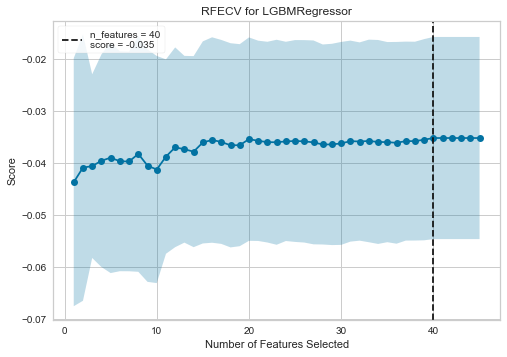

<AxesSubplot:title={'center':'RFECV for LGBMRegressor'}, xlabel='Number of Features Selected', ylabel='Score'>

In [15]:
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
import lightgbm as lgb
from yellowbrick.model_selection import RFECV

y = y.squeeze()

visualizer = RFECV(lgb.LGBMRegressor(), cv=block_cv, scoring= 'neg_root_mean_squared_error')

visualizer.fit(X, y)        # Fit the data to the visualizer
visualizer.show()           # Finalize and render the figure

In [42]:
pd.DataFrame(X.columns, index= visualizer.support_).loc[True]

,0
True,b1
True,b10
True,b11
True,b12
True,b13
True,b14
True,b15
True,b16
True,b17
True,b18


In [23]:
len(visualizer.estimator_.feature_importances_)

40

In [ ]:
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
import lightgbm as lgb
from yellowbrick.model_selection import RFECV

y = y.squeeze()

visualizer = RFECV(RandomForestRegressor(), cv=block_cv, scoring= 'neg_root_mean_squared_error')

visualizer.fit(X, y)        # Fit the data to the visualizer
visualizer.show()           # Finalize and render the figure